In [1]:
# Author: Saurav
# Edited on March 29th, 2021
# Code to access Brain MRI Data
# Code works as expected
# It uses DataTransform function similar to Ted's code
# Uses dataset assigned for Journal Paper of PnP
# Training Data: (refer notability notes) It uses 1541 (3T AXT2 volumes with coils >= 8) x 8 (bottom large brain slices) = 12328 image data from /storage/fastMRI_brain/data/multicoil_train
# Validation Data: (refer notability notes) It uses 421 (3T AXT2 volumes with coils >= 8) x 8 (bottom large brain slices) = 3368 image data from /storage/fastMRI_brain/data/multicoil_val
# The above numbers might be a rough estimate since a few images are left out because of size restiction and number of coil . I think the numbers are 12256 and 3352
# Finds the sensitivity map and stores the values as a file to be accessed by the denoiser

# old functionalities:
# It outputs stacked k-space data tensor as output 

# Code was written to help with Data processing for k-space Unet


import os
# import multiprocessing
# import pathlib
# os.chdir('..')

import random
import time
from collections import defaultdict

import numpy as np
import torch

from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
%matplotlib inline
import os

from espirit import espirit, espirit_proj, ifft, fft
# import bart
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

from common import utils
# from common.args import Args
# from common.args_new_brain import Args

from common.subsample import MaskFunc
from common.utils import tensor_to_complex_np
from common.evaluate import nmse, psnr
from skimage.measure import compare_ssim

from data import transforms
from data.brain_mri_data_UNet import SelectiveSliceData_Train
from data.brain_mri_data_UNet import SelectiveSliceData_Val
from data.multicoil_sim import get_coil_images, mask_coil_images

from models.PnP.dncnn import DnCNN
from models.PnP.train_denoiser_mid import load_model

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import lsqr

# from models.unet.run_unet_multi import optimal_scale

import scipy.misc
import PIL
import copy

import pathlib

import xml.etree.ElementTree as ET

import h5py

# code complete as of Dec 25, 2020

/home/shastri.19/anaconda3/envs/PnPNew/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
class Init_Arg:
    def __init__(self):
        self.seed=42
        self.resolution=384
        self.challenge='multicoil'
#         self.data_path='/storage/fastMRI/data/singlecoil_val' # uncomment this to run in GPU server
#         self.data_path='./singlecoil_val' 
#         self.data_path='/storage/fastMRI_brain/data/multicoil_val' 
        self.data_path_train = '/storage/fastMRI_brain/data/multicoil_train'
        self.data_path_val = '/storage/fastMRI_brain/data/multicoil_val'
        self.sample_rate=1.  
        self.accelerations=[4]
        self.center_fractions=[0.08]
        self.output_path = None
        self.snr = 20
        self.project = False
#         self.algorithm = 'pnp-admm'
        self.algorithm = 'pnp-pds'
#         self.algorithm = 'pnp-pds-desc'
#         self.algorithm = 'pnp-pds-mul-update'
        self.num_iters = 100
        self.inner_iters = 3
        self.inner_denoiser_iters = 1
        self.step_size = 0.1
        self.lamda = 0.01
        self.relaxation = 0.000
#         self.beta = 0.0005 #0.0005 works well, 0.001 gives okish results. 0.001 works good for admm
        self.beta = 0.0005 #0.0005 works well, 0.001 gives okish results. 0.001 works good for admm
        self.beta_desc = 0.04
        self.device=1
        self.denoiser_mode='2-chan'
#         self.checkpoint= '/storage/fastMRI/models/mid_3T_PD_denoisers/std0.02_L0.76_const_rot0/model.pt' #'/storage/fastMRI/models/mid_3T_PD_denoisers/std0.02_L0.76_const_rot0_rss-target/model.pt' # uncomment this to run in GPU server
#         self.checkpoint= '/storage/fastMRI/models/mid_3T_PD_denoisers/std0.02_L0.76_const_rot0_rss-target/model.pt'  # uncomment this to run in GPU server
#         self.checkpoint= 'models/mid_3T_PD_denoisers/std0.02_L0.76_const_rot0_rss-target/model.pt'
#         self.checkpoint= 'models/mid_3T_PD_denoisers/std0.02_L0.76_const_rot0/model.pt'
        self.checkpoint= 'Files_from_Server/models/mid_3T_PD_denoisers/std0.02_L0.76_const_rot0_rss-target/model.pt'
        self.debug=True
        self.test_idx=0 
        self.natural_image=False
        self.normalize='constant'
        self.rotation_angles=0
        self.accel=False
        self.use_mid_slices=True    
        self.scanner_strength=3
        self.scanner_mode = 'PD'
        self.run_name=None
#         self.mask_path = '/storage/fastMRI/mask.pt' # uncomment this to run in GPU server
        self.mask_path = 'masks/mask.pt'
#         self.mask_path = 'masks/mask2.pt'
#         self.mask_path = None
        self.resnorm=1
        self.resnorm_2=1
        self.noise_var = 1
        self.nc=4
#         self.nc=8
#         self.coil_root = '/storage/fastMRI/coil_maps/' # uncomment this to run in GPU server
        self.coil_root = 'coil_maps/'
        self.rss_target = True
#         self.rss_target = False
        self.optimal_scaling = False
#         self.espirit_cal = False
        self.espirit_cal = True
        self.map_num = 5
#         self.map_num = 6
        self.gamma_1 = 1;
        self.tresh_mul = 70;
        self.damp = 0.5;
        self.method_2 = True
        self.initialise_zero = False
        self.alpha_pdhg = 0.5
        self.eta_pdhg = 0.95
        self.delta_pdhg = 1.5 
        self.s_pdhg = 1
        self.set_gamma_1_2_equal = False
        self.use_1_norm_for_res = True
        self.mul_update_with_cap = True
        self.mul_update_cap_high = 2
        self.mul_update_cap_low = 0.5
        self.use_pre_determined_noise_var = True
        self.set_noise_variance = 5.3459594390181664e-11
        self.control_gamma_2 = 1
        self.use_only_x_and_z_residual = False
        self.PDS_theta = 1
        self.GAMMA = 1
        self.tresh_mul_2 = 10
        self.damp_2 = 0.4
        self.normalised_Ah_initialization = True
        self.use_damped_PDS_theta = False
        self.num_of_top_slices = 8

In [3]:
def flatten(t):
    t = t.reshape(1,-1)
    t = t.squeeze()
    return t

def unflatten(t,shape_t):
    t = t.reshape(shape_t)
    return t

def nmse_tensor(gt, pred):
    """ Compute Normalized Mean Squared Error (NMSE) """
    return torch.norm(gt - pred) ** 2 / torch.norm(gt) ** 2


In [4]:
class DataTransform:
    """
    Data Transformer for training U-Net models.
    """

    def __init__(self, args, use_seed=False):
        """
        Args:
            mask_func (common.subsample.MaskFunc): A function that can create  a mask of
                appropriate shape.
            resolution (int): Resolution of the image.
            which_challenge (str): Either "singlecoil" or "multicoil" denoting the dataset.
            use_seed (bool): If true, this class computes a pseudo random number generator seed
                from the filename. This ensures that the same mask is used for all the slices of
                a given volume every time.
        """
        self.use_seed = use_seed
        self.args = args
        self.mask = None
#         if args.mask_path is not None:
#             self.mask = torch.load(args.mask_path)

    def __call__(self, kspace, target, attrs, fname, slice):
        """
        Args:
            kspace (numpy.array): Input k-space of shape (num_coils, rows, cols, 2) for multi-coil
                data or (rows, cols, 2) for single coil data.
            target (numpy.array): Target image
            attrs (dict): Acquisition related information stored in the HDF5 object.
            fname (str): File name
            slice (int): Serial number of the slice.
        Returns:
            (tuple): tuple containing:
                image (torch.Tensor): Zero-filled input image.
                target (torch.Tensor): Target image converted to a torch Tensor.
                mean (float): Mean value used for normalization.
                std (float): Standard deviation value used for normalization.
                norm (float): L2 norm of the entire volume.
        """
        # GRO Sampling mask:
        a = np.array([0,10,19,28,37,46,54,61,69,76,83,89,95,101,107,112,118,122,127,132,136,140,144,148,151,155,158,161,164,
                 167,170,173,176,178,181,183,186,188,191,193,196,198,201,203,206,208,211,214,217,220,223,226,229,233,236,
                 240,244,248,252,257,262,266,272,277,283,289,295,301,308,315,323,330,338,347,356,365,374])
        m = np.zeros((384,384))
        m[:,a] = True
        m[:,176:208] = True
        samp = m
        numcoil = 8
        mask = np.tile(samp,(numcoil,1,1)).transpose((1,2,0)).astype(np.float32)
        nnz_index_mask = mask[0,:,0].nonzero()[0]

#         non_mask = np.ones([16,384,384])
#         non_mask[:,:,nnz_index_mask] = 0 
#         non_mask = transforms.to_tensor(non_mask)
        
#         print('kspace dimentions')
        kspace = kspace.transpose(1,2,0) 

        x = ifft(kspace, (0,1)) #(768, 396, 16)

        coil_compressed_x = ImageCropandKspaceCompression(x) #(384, 384, 8)

        RSS_x = np.squeeze(Rss(coil_compressed_x))# (384, 384)

        kspace = fft(coil_compressed_x, (1,0)) #(384, 384, 8)
        
        masked_kspace = kspace*mask
        
#         print(kspace.shape)
        kspace = transforms.to_tensor(kspace)
#         print(kspace.shape)
        kspace = kspace.permute(2,0,1,3)
    
    
        masked_kspace = transforms.to_tensor(masked_kspace)
#         print(kspace.shape)
        masked_kspace = masked_kspace.permute(2,0,1,3)
    
    

        kspace_np = tensor_to_complex_np(masked_kspace)

        ESPIRiT_tresh = 0.02
        ESPIRiT_crop = 0.96
        ESPIRiT_width_full = 24
        ESPIRiT_width_mask = 24
        device=sp.Device(0)
        
        sens_maps = mr.app.EspiritCalib(kspace_np,calib_width= ESPIRiT_width_mask,thresh=ESPIRiT_tresh, kernel_width=6, crop=ESPIRiT_crop,device=device,show_pbar=False).run()
        
        sens_maps = sp.to_device(sens_maps, -1)
        sens_map_foo = np.zeros((args.resolution,args.resolution,8)).astype(np.complex)
        for  i in range(8):
            sens_map_foo[:,:,i] = sens_maps[i,:,:]

        lsq_gt = np.sum(sens_map_foo.conj()*coil_compressed_x , axis = -1)   



    
        # Apply mask
        seed = None if not self.use_seed else tuple(map(ord, fname))

        nnz_index_mask = mask[0,:,0].nonzero()[0]
        
        ###################################
        
#         stacked_masked_kspace = torch.zeros(16, 384, 384)
#         stacked_masked_kspace[0:8,:,:] = torch.squeeze(masked_kspace[:,:,:,0])
#         stacked_masked_kspace[8:16,:,:] = torch.squeeze(masked_kspace[:,:,:,1])

#         stacked_kspace = torch.zeros(16, 384, 384)
#         stacked_kspace[0:8,:,:] = torch.squeeze(kspace[:,:,:,0])
#         stacked_kspace[8:16,:,:] = torch.squeeze(kspace[:,:,:,1])

#         return stacked_masked_kspace, mask, stacked_kspace, target, fname, slice
        return masked_kspace, mask, kspace, target, fname, slice, sens_map_foo, lsq_gt

In [5]:
def create_data_loader(args):

    train_data = SelectiveSliceData_Train(
        root=args.data_path_train,
        transform=DataTransform(args),
        challenge='multicoil',
        sample_rate=1,
        use_top_slices=True,
        number_of_top_slices=args.num_of_top_slices,
        fat_supress=None,
        strength_3T=None,
        restrict_size=False,
    )

    dev_data = SelectiveSliceData_Val(
        root=args.data_path_val,
        transform=DataTransform(args),
        challenge='multicoil',
        sample_rate=1,
        use_top_slices=True,
        number_of_top_slices=args.num_of_top_slices,
        fat_supress=None,
        strength_3T=None,
        restrict_size=False,
    )
        
    return dev_data, train_data


In [6]:
def Rss(x):
    y = np.expand_dims(np.sum(np.abs(x)**2,axis = -1)**0.5,axis = 2)
    return y

def ImageCropandKspaceCompression(x):
#     print(x.shape)
#     plt.imshow(np.abs(x[:,:,0]), origin='lower', cmap='gray')
#     plt.show()
        
    w_from = (x.shape[0] - 384) // 2  # crop images into 384x384
    h_from = (x.shape[1] - 384) // 2
    w_to = w_from + 384
    h_to = h_from + 384
    cropped_x = x[w_from:w_to, h_from:h_to,:]
    if cropped_x.shape[-1] >= 8:
        x_tocompression = cropped_x.reshape(384**2,cropped_x.shape[-1])
        U,S,Vh = np.linalg.svd(x_tocompression,full_matrices=False)
        coil_compressed_x = np.matmul(x_tocompression, Vh.conj().T)
        coil_compressed_x = coil_compressed_x[:,0:8].reshape(384,384,8)
    else:
        coil_compressed_x = cropped_x
        
    return coil_compressed_x

In [ ]:
args = Init_Arg()
dev_data, train_data = create_data_loader(args)

# args.add_noise = False
# stacked_masked_kspace, mask, stacked_kspace, target, fname, slice = data[15][0:6]


In [8]:
len(dev_data)

3352

In [10]:
len(train_data)

12256

In [28]:
masked_kspace, mask, kspace, target, fname, slice, sens_map_foo, lsq_gt  = dev_data[0][0:8]
print(fname)
print(slice)
fname_full = 'slice_' + str(slice) + '_' + fname
print(fname_full)

file_brain_AXT2_200_2000019.h5
0
slice_0_file_brain_AXT2_200_2000019.h5


In [30]:
mag_value = []

for i in range(len(dev_data)): #for Val data
    if i%500 == 0:
        print(i)
    masked_kspace, mask, kspace, target, fname, slice, sens_map_foo, lsq_gt  = dev_data[i][0:8]
    
    fname_full = 'slice_' + str(slice) + '_' + fname
    
    mag_value.append(np.max(np.abs(lsq_gt)))
    
    coil_sens_map_path = pathlib.Path('/storage/fastMRI_brain/Sens_Maps/8coil_val',fname_full)
    hf = h5py.File(coil_sens_map_path, 'w')
    hf.create_dataset('sens_map', data=sens_map_foo)
    hf.close()
    
print(np.max(mag_value))

0
500
1000
1500
2000
2500
3000
0.0013179313316112556


In [31]:
mag_value = []

for i in range(len(train_data)): #for train data
    if i%500 == 0:
        print(i)
    masked_kspace, mask, kspace, target, fname, slice, sens_map_foo, lsq_gt  = train_data[i][0:8]
    
    fname_full = 'slice_' + str(slice) + '_' + fname
    
    mag_value.append(np.max(np.abs(lsq_gt)))
    
    coil_sens_map_path = pathlib.Path('/storage/fastMRI_brain/Sens_Maps/8coil_train',fname_full)
    hf = h5py.File(coil_sens_map_path, 'w')
    hf.create_dataset('sens_map', data=sens_map_foo)
    hf.close()
    
print(np.max(mag_value))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
0.001681855660654293


In [12]:
# stacked_masked_kspace, mask, stacked_kspace, target, fname, slice = data[0][0:6]
stacked_masked_kspace, mask, stacked_kspace, target, fname, slice = data[0][0:6]

noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.8096)


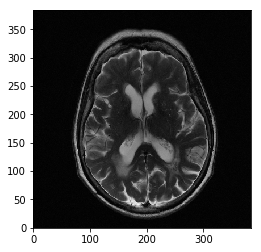

In [14]:
target.shape
target_2 = target[32:384-32,32:384-32]
target_2.shape
plt.imshow(target, origin='lower', cmap='gray')
plt.show()

noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.8213)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.8796)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.8195)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.2740)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.0562)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.1352)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.3826)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.3193)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.5113)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.2187)
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.4060)

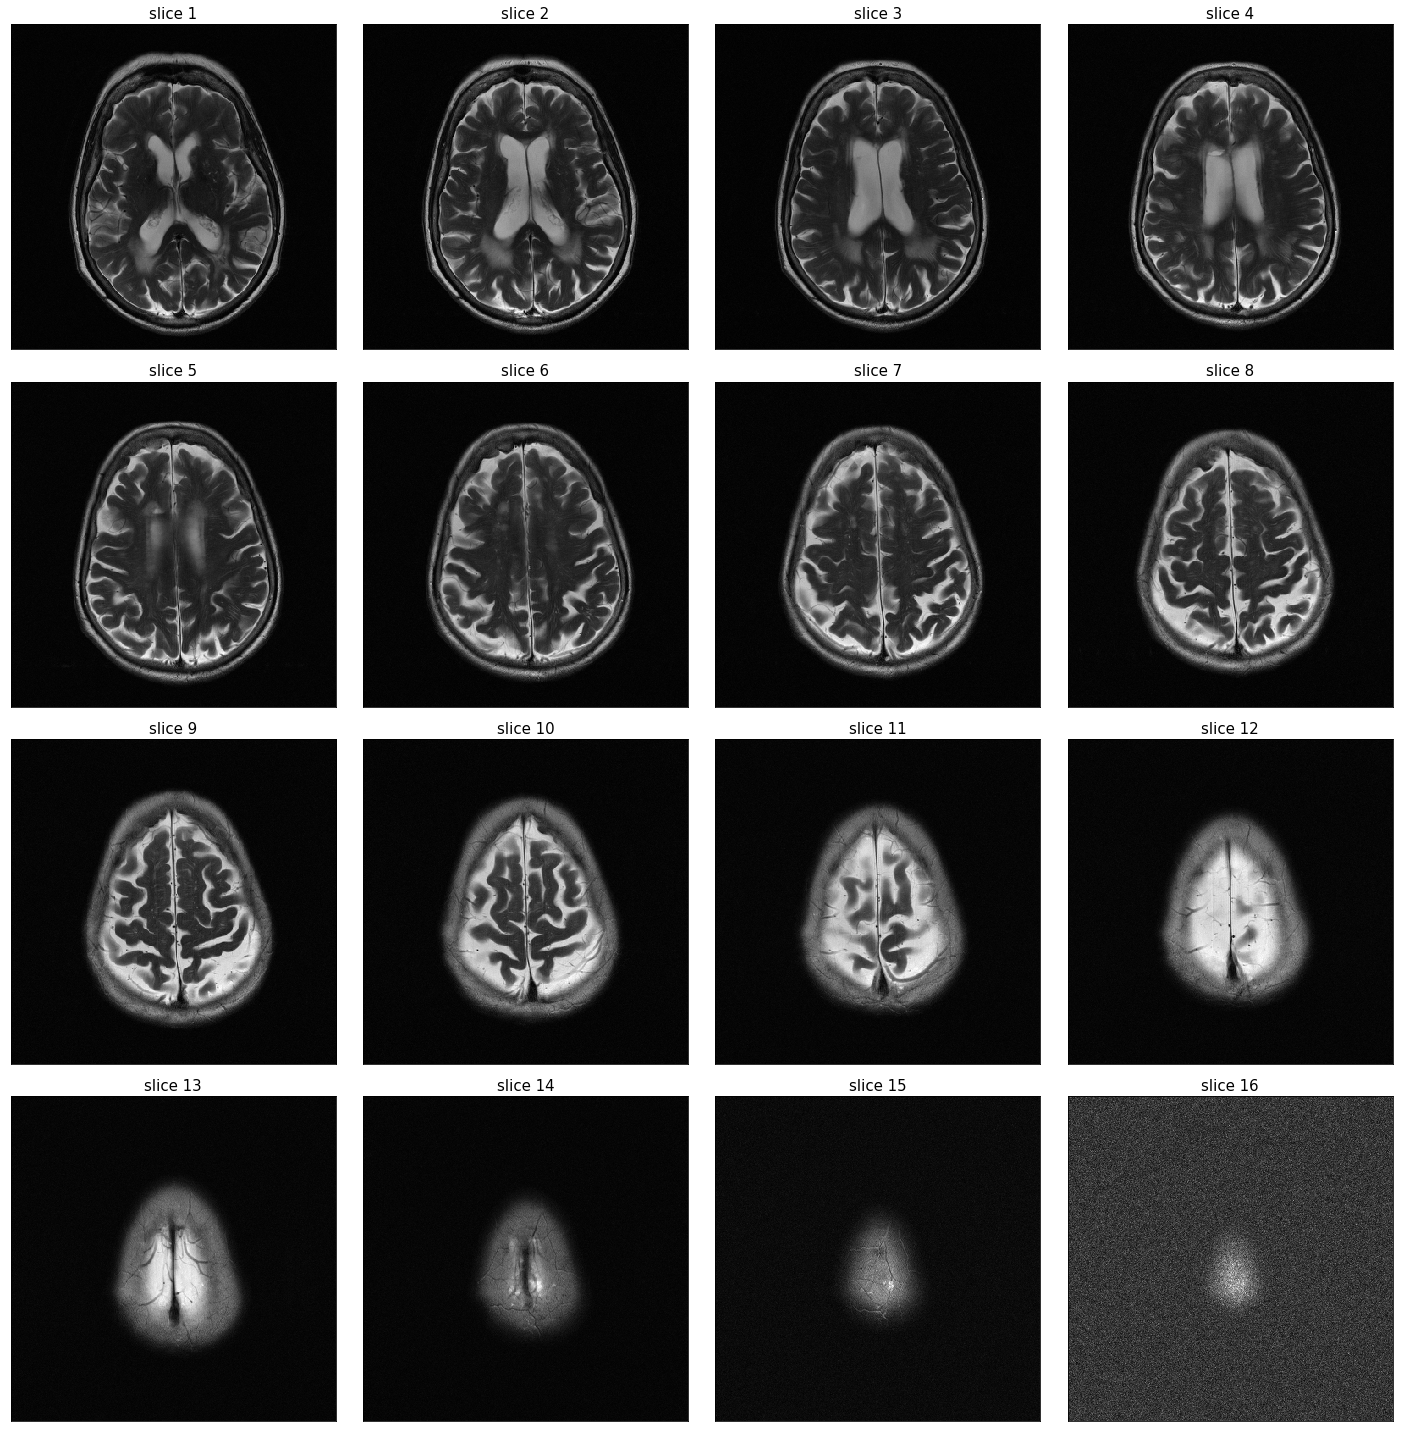

In [17]:
plt.figure(figsize=(20,20))

for slice_index in range(16):
    stacked_masked_kspace, mask, stacked_kspace, target, fname, slice = data[slice_index][0:6]
    plt.subplot(4,4,slice_index+1)  
    plt.imshow(target, origin='lower', cmap='gray')
    plt.title('slice ' +str(slice_index+1),fontsize=15)
    plt.xticks([])
    plt.yticks([])
#     plt.colorbar()
    plt.tight_layout()
plt.savefig("Results/brain_slice_images/Brain_slice_images1.pdf",format ="pdf")
plt.show()

In [43]:
kspace = data[20][2]
kspace
# 5.3459594390181664e-11

HI
264
noise variance of this run:
5.3459594390181664e-11
SNR in dB for this run:
tensor(21.7170)


tensor([[[-4.4900e-06, -3.0420e-06,  4.8850e-06,  ...,  1.1248e-05,
          -4.1309e-06, -6.0025e-07],
         [ 7.0140e-06,  5.2156e-06, -1.9050e-06,  ..., -1.8196e-06,
           8.4070e-07, -1.4692e-06],
         [ 3.7331e-06,  1.2214e-06,  3.8959e-06,  ..., -3.9400e-06,
           4.1247e-06, -7.2356e-06],
         ...,
         [ 1.2580e-05, -9.8711e-07, -5.1936e-06,  ..., -3.0376e-06,
           1.1777e-05,  7.6957e-07],
         [ 4.5218e-06,  3.8688e-06, -1.1115e-05,  ...,  3.1372e-06,
          -2.3090e-06,  2.3034e-06],
         [-1.4223e-05,  1.1470e-05,  1.1043e-05,  ..., -2.1412e-07,
          -1.5789e-06, -2.8572e-06]],

        [[-2.4908e-06, -4.1502e-07,  3.8577e-06,  ..., -1.0762e-06,
           2.3833e-06, -2.1128e-06],
         [-4.9101e-06,  4.5502e-06,  9.9007e-06,  ...,  2.0670e-06,
           2.4613e-06,  1.3693e-06],
         [ 5.0569e-06,  1.0763e-06, -5.5615e-06,  ..., -7.1560e-07,
           3.9052e-06, -7.1556e-06],
         ...,
         [-1.6623e-06,  9

In [25]:
data[][2].mean()

SyntaxError: invalid syntax (<ipython-input-25-c55d32abe892>, line 1)

In [10]:
mean_collection = 0
std_collection = 0
for i in range(1884):
    mean_collection = mean_collection + data[i][2].mean()
    std_collection = std_collection + data[i][2].std()
    if i%50==0:
#     print('data index')
        print(i)

print('mean of means:')
print(mean_collection/2130)
print('mean of std:')
print(std_collection/2130)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
mean of means:
tensor(-4.0156e-11)
mean of std:
tensor(2.5036e-05)


In [11]:
mean of means:
tensor(-4.0156e-11)
mean of std:
tensor(2.5036e-05)

SyntaxError: invalid syntax (<ipython-input-11-f0369943975e>, line 1)

In [59]:
stacked_masked_kspace = torch.zeros(16,384, 384)
stacked_masked_kspace[0:8,:,:] = torch.squeeze(masked_ksapce[:,:,:,0])
stacked_masked_kspace[8:16,:,:] = torch.squeeze(masked_ksapce[:,:,:,1])

stacked_masked_kspace[:,0,0]

tensor([-1.2276e-07, -5.9014e-06, -3.9271e-06,  1.2531e-06, -2.1592e-06,
         3.3174e-06, -4.3521e-07,  5.3696e-06, -3.0222e-06, -6.4180e-06,
        -1.0573e-06,  1.8553e-06,  2.5737e-07,  8.1433e-06,  4.6825e-06,
        -3.5429e-06])

In [32]:
torch.squeeze(masked_ksapce[:,:,:,0]).shape

torch.Size([8, 384, 384])

In [50]:
stacked_masked_kspace = torch.zeros(16,384, 384)
stacked_masked_kspace[8:16,:,:].shape

torch.Size([8, 384, 384])

torch.Size([16, 10, 10])

tensor([[[7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         ...,
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.]],

        [[7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         ...,
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.]],

        [[7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         ...,
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.]],

        ...,

        [[7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7.,  ..., 7., 7., 7.],
         ...,
         [7., 7., 7.,  ..., 7., 7., 7.],
         [7., 7., 7., 

In [102]:
from torch.nn import functional as F

In [116]:
F.mse_loss(b,a)

tensor(9.)

In [130]:
torch.min(abs(kspace))

tensor(1.1842e-14)

In [144]:
kspace.std()

tensor(2.6868e-05)